# figure demonstrating the principles of event-based cameras

inspiration from https://lenzgregor.com/posts/event-cameras/



In [1]:
bias = .3
N_threshold = 25
N_frame = 30
smoothing = 10.0
smoothing = 15.0

In [2]:
import os
import numpy as np
phi = np.sqrt(5)/2 + 1/2
import matplotlib
import matplotlib.pyplot as plt

import matplotlib
subplotpars = matplotlib.figure.SubplotParams(left=0.125, right=.95, bottom=0.25, top=.975, wspace=0.05, hspace=0.05,)

figpath = None
figpath = '.'

dpi = 300
ext = 'svg'

def printfig(fig, name, ext=ext, figpath=figpath, dpi=None, bbox='tight'):
    fig.savefig(os.path.join(figpath, name + '.' + ext), dpi = dpi, bbox_inches=bbox, transparent=True)

if not(figpath is None): os.makedirs(figpath, exist_ok=True)

# define signal

Get a raw signal, time-filter it

In [3]:
fname = '/Users/laurentperrinet/Documents/GitHub/MotionClouds/docs/files/montypython.npy'
movie = np.exp(np.load(fname))
movie.shape

(54, 54, 4096)

In [4]:
i_x, i_y = 0, 0
i_t_start, i_t_end = 0, 5000
i_t_start, i_t_end = 1500, 2500
i_t_middle = (i_t_end - i_t_start) //2
movie_line = movie[i_x, i_y, i_t_start:i_t_end] - bias

(1000,)

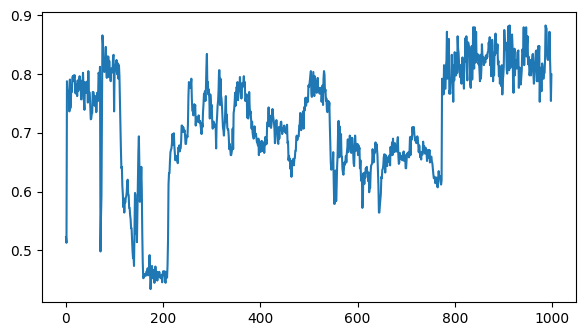

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(phi*4, 4), subplotpars=subplotpars)
ax.plot(movie_line)
movie_line.shape

In [6]:
# from scipy.signal import spline_filter
from scipy.signal import cspline1d, cspline1d_eval
time = np.linspace(0, i_t_end - i_t_start, 500)
movie_line = cspline1d_eval(cspline1d(movie_line, smoothing), time)
movie_line.shape, time.shape

((500,), (500,))

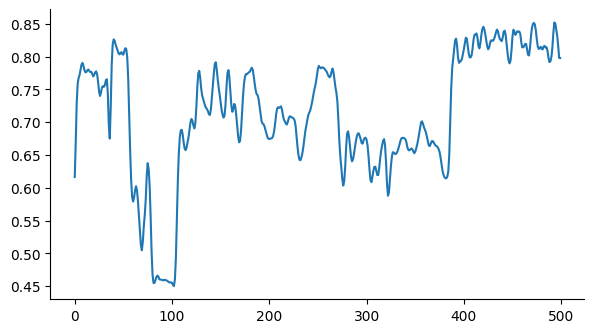

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(phi*4, 4), subplotpars=subplotpars)
ax.plot(movie_line)

# ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
# ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')

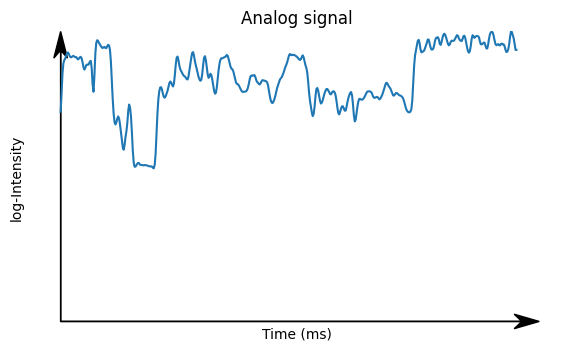

In [8]:
def do_plot(movie_line, N_frame=0, N_threshold=0,
            ylabel='log-Intensity',
            xlabel='Time (ms)',
            title='Analog signal',
):
    fig, ax = plt.subplots(1, 1, figsize=(phi*4, 4), subplotpars=subplotpars)
    ax.plot(movie_line)
    ax.set_ylim(0, movie_line.max())

    # ax.spines['left'].set_position('center')
    ax.spines['right'].set_color('none')
    # ax.spines['bottom'].set_position('center')
    ax.spines['top'].set_color('none')

    # https://3diagramsperpage.wordpress.com/2014/05/25/arrowheads-for-axis-in-matplotlib/
    # removing the default axis on all sides:
    for side in ['bottom','right','top','left']:
        ax.spines[side].set_visible(False)
    
    # removing the axis ticks
    plt.xticks([]) # labels 
    plt.yticks([])
    ax.xaxis.set_ticks_position('none') # tick markers
    ax.yaxis.set_ticks_position('none')

    # matching arrowhead length and width

    xmin, xmax = ax.get_xlim() 
    ymin, ymax = ax.get_ylim()
    dps = fig.dpi_scale_trans.inverted()
    bbox = ax.get_window_extent().transformed(dps)
    width, height = bbox.width, bbox.height
    
    # manual arrowhead width and length
    hw = 1./20.*(ymax-ymin) 
    hl = 1./20.*(xmax-xmin)
    lw = 1. # axis line width
    ohg = 0.3 # arrow overhang
    
    # compute matching arrowhead length and width
    yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width 
    yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height
    
    # draw x and y axis
    ax.arrow(0, 0, xmax, 0., fc='k', ec='k', lw = lw, 
            head_width=hw, head_length=hl, overhang = ohg, 
            length_includes_head= True, clip_on = False) 
    
    ax.arrow(0, 0, 0., ymax, fc='k', ec='k', lw = lw, 
            head_width=yhw, head_length=yhl, overhang = ohg, 
            length_includes_head= True, clip_on = False) 
    ax.set_ylabel(ylabel)

    ax.set_xlabel(xlabel)
    ax.set_title(title)

    if N_frame>0:
        
        samples = np.linspace(0, int(xmax*.95), N_frame, dtype=int)
        for i_sample, sample in enumerate(samples):
            ax.plot([sample, sample], [0, ymax], 'k--', lw=.2)
            ax.plot([sample], [movie_line[sample]], 'o', color='orangered', fillstyle='none', lw=1)


    if N_threshold>0:
        
        ysamples = np.linspace(0, ymax, N_threshold)
        for i_ysample, ysample in enumerate(ysamples):
            ax.plot([0, xmax], [ysample, ysample], 'k--', lw=.2)

        events_up = []
        events_down = []

        threshold = ymax / N_threshold
        i_buffer = int(movie_line[0] * N_threshold / ymax)
        buffer = ysamples[i_buffer]

        for i_time in range(len(movie_line)):
            amp = movie_line[i_time]
            while np.abs(amp-buffer)>threshold:
                if (amp-buffer)>threshold:
                    events_up.append(i_time)
                    buffer += threshold
                elif -(amp-buffer)>threshold:
                    events_down.append(i_time)
                    buffer -= threshold

        for i_time in events_up:
            ax.plot([i_time], [movie_line[i_time]], 'r^', alpha=.4)
            ax.plot([i_time, i_time], [0, ymax/N_threshold], 'r', lw=.5)
        for i_time in events_down:
            ax.plot([i_time], [movie_line[i_time]], 'bv', alpha=.4)
            ax.plot([i_time, i_time], [0, ymax/N_threshold], 'b', lw=.5)

    return fig, ax

fig, ax = do_plot(movie_line)


In [9]:
printfig(fig, 'analog_signal')

# do frames

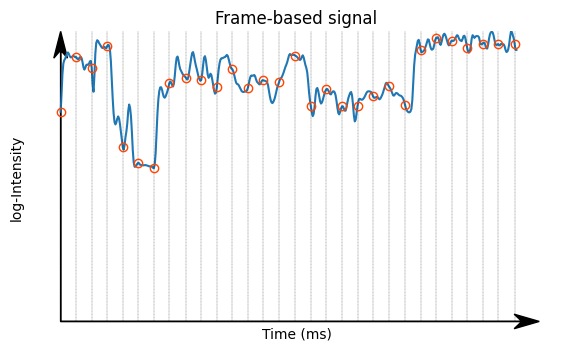

In [10]:
fig, ax = do_plot(movie_line, N_frame=N_frame, title='Frame-based signal')
printfig(fig, 'frame-based_signal')

# do events

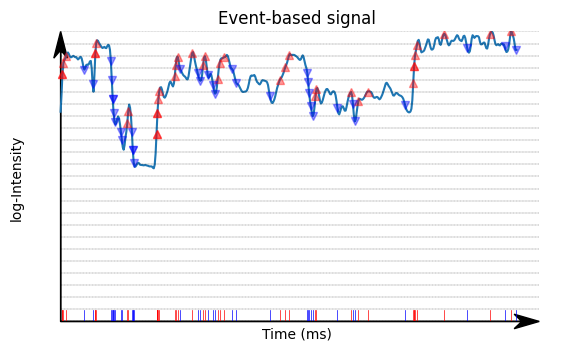

In [11]:
fig, ax = do_plot(movie_line, N_threshold=N_threshold, title='Event-based signal')
printfig(fig, 'event-based_signal')

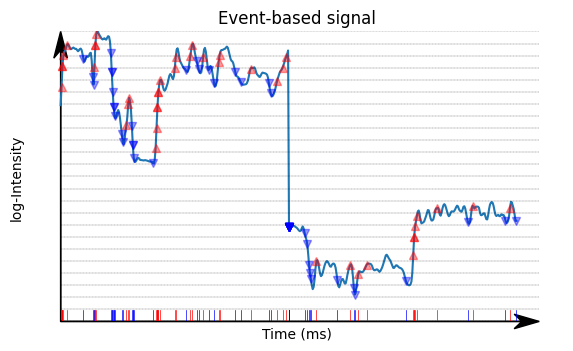

In [12]:
movie_line_low = movie_line.copy()
movie_line_low[len(movie_line)//2:] -= 15 * (movie_line.max() / N_threshold)
fig, ax = do_plot(movie_line_low, N_threshold=N_threshold, title='Event-based signal')
printfig(fig, 'event-based_signal_low')